# Trial phase characterization

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy import stats

# --Machine learning and statistics+
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from one.api import ONE
import matplotlib.pyplot as plt

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from plotting_functions import bins_per_trial_phase, broader_label

one = ONE(base_url='https://alyx.internationalbrainlab.org')

## Parameters

In [2]:
bin_size = 0.1

data_path_v1 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v1/' + str(bin_size) + '/'
data_path_v2 =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'
# data_path_v2 =  '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v2_3Nov2023/' + str(bin_size) + '/'

data_path = data_path_v2

os.chdir(data_path)
design_matrices = os.listdir(data_path)

if data_path == data_path_v1:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
              'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
              'pupil_speed_Y', 'Gaussian_licks']
elif data_path == data_path_v2:
       var_names = ['avg_wheel_vel', 'pupil_diameter',
              'whisker_me', 'nose_speed', 'l_paw_speed', 'left_X', 'left_Y',
              'pupil_speed', 'pupil_X', 'pupil_Y', 'Lick count']

# Plotting params
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

## Load data

List design matrices' eids

In [3]:
# Save data of all sessions for latter
idxs = []
mouse_names = []
for m, mat in enumerate(design_matrices):
    
    mouse_name = design_matrices[m][51:-4]
    eid = design_matrices[m][14:50]
    idx = str(eid + '_' + mouse_name)
    if m == 0:
        idxs = idx
        mouse_names = mouse_name
    else:
        idxs = np.hstack((idxs, idx))
        mouse_names = np.hstack((mouse_names, mouse_name))

In [4]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)
epoch_df = defaultdict(list)

for m, mouse_name in enumerate(mouse_names):
    # Save results per mouse
    matrix_all[mouse_name] = {}
    session_all[mouse_name] = {}
    matrix_all_unnorm[mouse_name] = {}
    epoch_df[mouse_name] = {}
    
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        mouse_name = mat[37:]

        session_trials = one.load_object(session, obj='trials', namespace='ibl')
        session_trials = session_trials.to_df()
        session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
        session_start = list(session_trials['stimOn_times'])[0]

        # Get time of last unbiased trial
        unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
        time_trial_90 = list(unbiased['stimOff_times'])[-1]
        
        filename = str('design_matrix_' + mat + '_'  + str(bin_size))  # + mouse_name + '_'
                
        big_design_matrix = pickle.load(open(filename, "rb"))
        design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
        design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
        design_matrix = design_matrix.dropna()
    
        # Keep only first 90 trials
        design_matrix = design_matrix.loc[(design_matrix['Bin'] < time_trial_90 * 10) & (design_matrix['Bin'] > session_start * 10)]
        unbiased_trials = session_trials.loc[session_trials['stimOff_times'] < time_trial_90]
        training_set = np.array(design_matrix[var_names]).copy() 

        # Get trial epoch
        bins_df = bins_per_trial_phase(design_matrix, session_trials)
        bins_df = bins_df.rename(columns={0: 'Bin'})
        new_df = design_matrix.merge(bins_df, on='Bin')
        new_df = broader_label(new_df)
        
        if len(training_set) > 0:
            # Standardization using StandardScaler
            scaler = StandardScaler()
            standardized = scaler.fit_transform(training_set)
            # Normalize between 0 and 1
            normalizer = Normalizer().fit(standardized)
            normalized = normalizer.transform(standardized)
            
            matrix_all[mouse_name][session] = normalized
            session_all[mouse_name][session] = unbiased_trials    
            matrix_all_unnorm[mouse_name][session] = design_matrix
            epoch_df[mouse_name][session] = new_df
            
        else:
            print(session)
    else:
        print(mat)

/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

poch_DY_013.png_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

portances.svg_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

lls_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

poch_CSHL060.png_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

_matrix_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

1b61b7f2-a599-4e40-abd6-3e758d2c9e25
_


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

## Concatenate sessions of the same animal

In [5]:
collapsed_matrices = defaultdict(list)
collapsed_unnorm = defaultdict(list)
collapsed_trials = defaultdict(list)

# Collapse multiple sessions per mouse
for mouse in np.unique(mouse_names):
    if len(np.where(mouse_names==mouse)[0]) > 1 and len(mouse) > 0:
        mouse_sessions = list(matrix_all[mouse].keys())
        for s, session in enumerate(mouse_sessions):
            collapsed_matrices[mouse] = np.vstack(matrix_all[mouse][session])
            collapsed_unnorm[mouse] = np.vstack(matrix_all_unnorm[mouse][session])
            collapsed_trials[mouse] = pd.concat(session_all[mouse], ignore_index=True)

In [6]:
def stats_features_per_epoch(use_data, hue, label):
    
    bins_df = bins_per_trial_phase(use_data, session_trials)
    bins_df = bins_df.rename(columns={0: 'Bin'})
    new_df = use_data.merge(bins_df, on='Bin')
    new_df['side'] = np.sign(new_df['signed_contrast'])
    new_df.loc[new_df['side']==0] = np.nan

    new_df['broader_label'] = new_df['label']
    new_df.loc[new_df['broader_label']=='Stimulus right', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Stimulus left', 'broader_label'] = 'Stimulus'
    new_df.loc[new_df['broader_label']=='Quiescence', 'broader_label'] = 'Quiescence'
    new_df.loc[new_df['broader_label']=='Left choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Right choice', 'broader_label'] = 'Choice'
    new_df.loc[new_df['broader_label']=='Correct feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='Incorrect feedback', 'broader_label'] = 'Feedback'
    new_df.loc[new_df['broader_label']=='ITI_correct', 'broader_label'] = 'ITI'
    new_df.loc[new_df['broader_label']=='ITI_incorrect', 'broader_label'] = 'ITI'
    new_df = new_df.dropna()
    
    trial_epochs = new_df[label].unique()
    hues = new_df[hue].unique()
    vars = new_df.keys()[0:11]

    p_values = pd.DataFrame(columns=['var', 'epoch', 'significance'])
    for v, var in enumerate(vars):
        var_data = new_df[['Bin', label, var, hue]]
        
        for e, epoch in enumerate(trial_epochs):
            epoch_data = var_data.loc[var_data[label]==epoch]
            
            group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
            group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
            
            _, p_v = stats.ttest_ind(group_1, group_2)

            # Save results
            p_value = pd.DataFrame(columns=['var', 'epoch', 'significance'], index=range(1))
            p_value['var'] = var
            p_value['epoch'] = epoch
            if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
                p_value['significance'] = 'Significantly higher'
            elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
                p_value['significance'] = 'Significantly smaller'
            elif p_v >= 0.05:
                p_value['significance'] = 'Non significant'
                
            # Append
            p_values = pd.concat([p_values, p_value], ignore_index=True)
    
    # Plot 
    if hue in ['choice', 'side']:
        hue_names = np.array(['left', 'right'])
        hue_numbers = np.array([-1.0, 1.0])
    elif hue == 'correct':
        hue_names = np.array(['correct', 'incorrect'])
        hue_numbers = np.array([1., 0.])
    sns.catplot(y='var', x='significance', hue='epoch', data=p_values, 
    order=['Non significant', 'Significantly higher', 'Significantly smaller'],
    height=5, aspect=2)

    plt.title(str('Modulation by ' + hue + ' ' + str(hue_names[np.where(hue_numbers==hues[1])]) + 
                ' - ' + str(hue_names[np.where(hue_numbers==hues[0])])))
    plt.show()
            
    return p_values   

    
def stats_features_per_epoch_sess(idxs, session_all, matrix_all, matrix_all_unnorm, hue, label):
    
    p_values = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'])
    
    for m, mat in enumerate(idxs):
        if len(mat) > 35: 
                
            # Trials data
            session = mat[0:36]
            # Mouse name
            mouse_name = mat[37:]
            
            print('Testing mouse ' + mouse_name)

            # Get mouse data
            session_trials = session_all[mouse_name][session]
            design_matrix = matrix_all[mouse_name][session]
            unnorm_mat = matrix_all_unnorm[mouse_name][session]
            
            if len(np.shape(design_matrix)) > 2:
                design_matrix = design_matrix[0]
                session_trials = session_trials[0]
                unnorm_mat = matrix_all_unnorm[mouse_name][0]
            
            " Prepare design matrix "
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix
            bins = unnorm_mat['Bin']
            design_matrix_heading['Bin'] = bins
            
            design_matrix_heading['Lick count'] = gaussian_filter1d(design_matrix_heading['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
            #plt.hist(use_data['Lick count'])
            design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])

            " Prepare data for plotting "
            bins_df = bins_per_trial_phase(design_matrix_heading, session_trials)
            bins_df = bins_df.rename(columns={0: 'Bin'})
            new_df = design_matrix_heading.merge(bins_df, on='Bin')
            new_df['side'] = np.sign(new_df['signed_contrast'])
            new_df.loc[new_df['side']==0] = np.nan

            new_df = broader_label(new_df)
            new_df = new_df.dropna()
            
            trial_epochs = new_df[label].unique()
            hues = new_df[hue].unique()
            vars = new_df.keys()[0:11]

            for v, var in enumerate(vars):
                var_data = new_df[['Bin', label, var, hue]]
                
                for e, epoch in enumerate(trial_epochs):
                    epoch_data = var_data.loc[var_data[label]==epoch]
                    
                    group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
                    group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
                    
                    _, p_v = stats.ttest_ind(group_1, group_2)

                    # Save results
                    p_value = pd.DataFrame(columns=['mouse', 'var', 'epoch', 'significance'], index=range(1))
                    p_value['mouse'] = mouse_name
                    p_value['var'] = var
                    p_value['epoch'] = epoch
                    if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
                        p_value['significance'] = 'Significantly higher'
                    elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
                        p_value['significance'] = 'Significantly smaller'
                    elif p_v >= 0.05:
                        p_value['significance'] = 'Non significant'
                        
                    # Append
                    p_values = pd.concat([p_values, p_value], ignore_index=True)
            
    return p_values 

## Loop through animals

In [217]:
broader = True
var = 'broader_label'

for m, mat in enumerate(idxs[0:1]):
    if len(mat) > 35: 
        
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
        
        print('Testing mouse ' + mouse_name)

        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        epoch_matrix = epoch_df[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
            # epoch =  epoch_df[mouse_name][session] = new_df



Testing mouse SWC_052


In [158]:
def shuffle_control(trials_df, choice_model):
    
    shuffled_df = pd.DataFrame(columns=['Trial', 'side', 'choice', 'feedback'])

    shuffled_df['Trial'] = trials_df['Trial']
    shuffled_df['side'] = trials_df['side'].sample(frac=1).reset_index(drop=True)
    shuffled_df = shuffled_df.reset_index()

    # Compute choices from choice model
    stim_l_choice = np.where(shuffled_df['side'] == -1.)
    stim_r_choice = np.where(shuffled_df['side'] == 1.)
    
    # Choice probability
    fraction_stim_l = list(choice_model.loc[choice_model['side']==-1, 'choice'])[0]
    fraction_stim_r = list(choice_model.loc[choice_model['side']==1, 'choice'])[0]

    # Calculate the number of indexes to select
    num_indexes_stim_l = int(len(stim_l_choice[0]) * fraction_stim_l)
    num_indexes_stim_r = int(len(stim_r_choice[0]) * fraction_stim_r)

    # Generate random indices
    random_choice_r_stim_l = np.random.choice(len(stim_l_choice[0]), size=num_indexes_stim_l, replace=False)
    random_choice_r_stim_r = np.random.choice(len(stim_r_choice[0]), size=num_indexes_stim_r, replace=False)

    # Select values from the array using the random indices
    selected_values_stim_l = stim_l_choice[0][random_choice_r_stim_l]
    selected_values_stim_r = stim_r_choice[0][random_choice_r_stim_r]


    shuffled_df.loc[shuffled_df['index'].isin(selected_values_stim_l), 'choice'] = 1.
    shuffled_df.loc[shuffled_df['index'].isin(selected_values_stim_r), 'choice'] = 1.
    shuffled_df.loc[shuffled_df['choice']!=1., 'choice'] = -1.
    
    shuffled_df.loc[shuffled_df['side']==shuffled_df['choice'], 'feedback'] = 0
    shuffled_df.loc[shuffled_df['side']!=shuffled_df['choice'], 'feedback'] = 1
    
    return shuffled_df


In [221]:
iters = 10
label = 'broader_label'
hue = 'choice'
var = 'avg_wheel_vel'

epoch_matrix['side'] = np.sign(epoch_matrix['signed_contrast'])
epoch_matrix.loc[epoch_matrix['side']==0] = np.nan

trial_epochs = epoch_matrix.dropna()[label].unique()
hues = epoch_matrix[hue].unique()
non_nan = np.isnan(hues)
hues = hues[~non_nan]
hues = [-1., 1.]

epoch_matrix.loc[epoch_matrix['choice']==-1., 'choice'] = 0

trials_df = epoch_matrix[['Trial', 'feedback', 'signed_contrast', 'side', 'choice']].dropna().groupby('Trial').mean().reset_index()
choice_model = trials_df[['Trial', 'side', 'choice']].groupby('side').mean(['choice']).reset_index()

# Get results for shuffles
shuffle_stats = pd.DataFrame(columns=['iter', 'var', 'epoch', 'diff'])

for i in range(iters):
    shuffled_df = shuffle_control(trials_df, choice_model)
    merged_df = epoch_matrix[['Trial', 'Bin', 'avg_wheel_vel', 'pupil_diameter', 'whisker_me', 'nose_speed',
       'l_paw_speed', 'left_X', 'left_Y', 'pupil_speed', 'pupil_X', 'pupil_Y',
       'Lick count', label]].merge(shuffled_df, on='Trial')
    
    var_data = merged_df[['Bin', label, var, hue]]
    epoch_stats = pd.DataFrame(columns=['iter', 'var', 'epoch', 'diff'], index=range(len(trial_epochs)))
    
    for e, epoch in enumerate(trial_epochs):
        epoch_data = var_data.loc[var_data[label]==epoch]
        
        group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
        group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
        
        # Save data
        epoch_stats['iter'][e] = i
        epoch_stats['var'][e] = var
        epoch_stats['epoch'][e] = epoch
        epoch_stats['diff'][e] = np.nanmean(group_1) - np.nanmean(group_2)  # left choice minus right choice
    
    if i == 0:
        shuffle_stats = epoch_stats
    else:
        shuffle_stats = shuffle_stats.append(epoch_stats)
        

/tmp/ipykernel_23155/4035500472.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shuffle_stats = shuffle_stats.append(epoch_stats)
/tmp/ipykernel_23155/4035500472.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shuffle_stats = shuffle_stats.append(epoch_stats)
/tmp/ipykernel_23155/4035500472.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shuffle_stats = shuffle_stats.append(epoch_stats)
/tmp/ipykernel_23155/4035500472.py:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  shuffle_stats = shuffle_stats.append(epoch_stats)
/tmp/ipykernel_23155/4035500472.py:47: FutureWarning: The frame.append method is deprecated and will be 

In [223]:
shuffle_stats

,iter,var,epoch,diff
0,0,avg_wheel_vel,Choice,-0.719308
1,0,avg_wheel_vel,ITI,0.337519
2,0,avg_wheel_vel,Quiescence,-0.07672
3,0,avg_wheel_vel,Stimulus,-0.000309
0,1,avg_wheel_vel,Choice,-0.017178
1,1,avg_wheel_vel,ITI,0.131796
2,1,avg_wheel_vel,Quiescence,0.004251
3,1,avg_wheel_vel,Stimulus,-0.061399
0,2,avg_wheel_vel,Choice,0.444753
1,2,avg_wheel_vel,ITI,-0.090757


In [213]:
hues

array([1., 0.])

In [212]:
epoch_data

,Bin,broader_label,avg_wheel_vel,choice
39,798.0,Stimulus,-0.007631,-1.0
40,799.0,Stimulus,-1.896699,-1.0
84,892.0,Stimulus,-0.003578,-1.0
85,893.0,Stimulus,-1.623573,-1.0
107,1031.0,Stimulus,-0.008063,-1.0
...,...,...,...,...
1802,5799.0,Stimulus,0.251487,-1.0
1834,5843.0,Stimulus,3.157295,-1.0
1854,5977.0,Stimulus,0.006635,-1.0
2068,6813.0,Stimulus,0.012388,-1.0


In [26]:


epoch_matrix['side'] = np.sign(epoch_matrix['signed_contrast'])
# epoch_matrix.loc[epoch_matrix['side']==0] = np.nan

trial_epochs = epoch_matrix[label].unique()
hues = epoch_matrix[hue].unique()
non_nan = np.isnan(hues)
hues = hues[~non_nan]

# vars = epoch.keys()[0:11]

p_values = pd.DataFrame(columns=['var', 'epoch', 'significance'])
for v, var in enumerate(var_names):
    var_data = new_df[['Bin', label, var, hue]]
    
    for e, epoch in enumerate(trial_epochs):
        epoch_data = var_data.loc[var_data[label]==epoch]
        
        group_1 = epoch_data.loc[epoch_data[hue]==hues[0], var]
        group_2 = epoch_data.loc[epoch_data[hue]==hues[1], var]
        
        _, p_v = stats.ttest_ind(group_1, group_2)

        # Save results
        p_value = pd.DataFrame(columns=['var', 'epoch', 'significance'], index=range(1))
        p_value['var'] = var
        p_value['epoch'] = epoch
        if (np.nanmean(group_2) > np.nanmean(group_1)) and (p_v < 0.05):
            p_value['significance'] = 'Significantly higher'
        elif (np.nanmean(group_2) < np.nanmean(group_1)) and (p_v < 0.05):
            p_value['significance'] = 'Significantly smaller'
        elif p_v >= 0.05:
            p_value['significance'] = 'Non significant'
            
        # Append
        p_values = pd.concat([p_values, p_value], ignore_index=True)

# Plot 
if hue in ['choice', 'side']:
    hue_names = np.array(['left', 'right'])
    hue_numbers = np.array([-1.0, 1.0])
elif hue == 'correct':
    hue_names = np.array(['correct', 'incorrect'])
    hue_numbers = np.array([1., 0.])
sns.catplot(y='var', x='significance', hue='epoch', data=p_values, 
order=['Non significant', 'Significantly higher', 'Significantly smaller'],
height=5, aspect=2)

plt.title(str('Modulation by ' + hue + ' ' + str(hue_names[np.where(hue_numbers==hues[1])]) + 
            ' - ' + str(hue_names[np.where(hue_numbers==hues[0])])))
plt.show()
            

IndexError: index 1 is out of bounds for axis 0 with size 1

## Plot modulation of behavior by different task variables at different trial epochs

Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

Fitting mouse ZFM-02369


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse SWC_061


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse CSHL049


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse NR_0019


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse ZFM-02369


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse SWC_061


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse CSHL049


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse NR_0019


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse ZFM-02369


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse SWC_061


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse CSHL049


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

Fitting mouse NR_0019


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

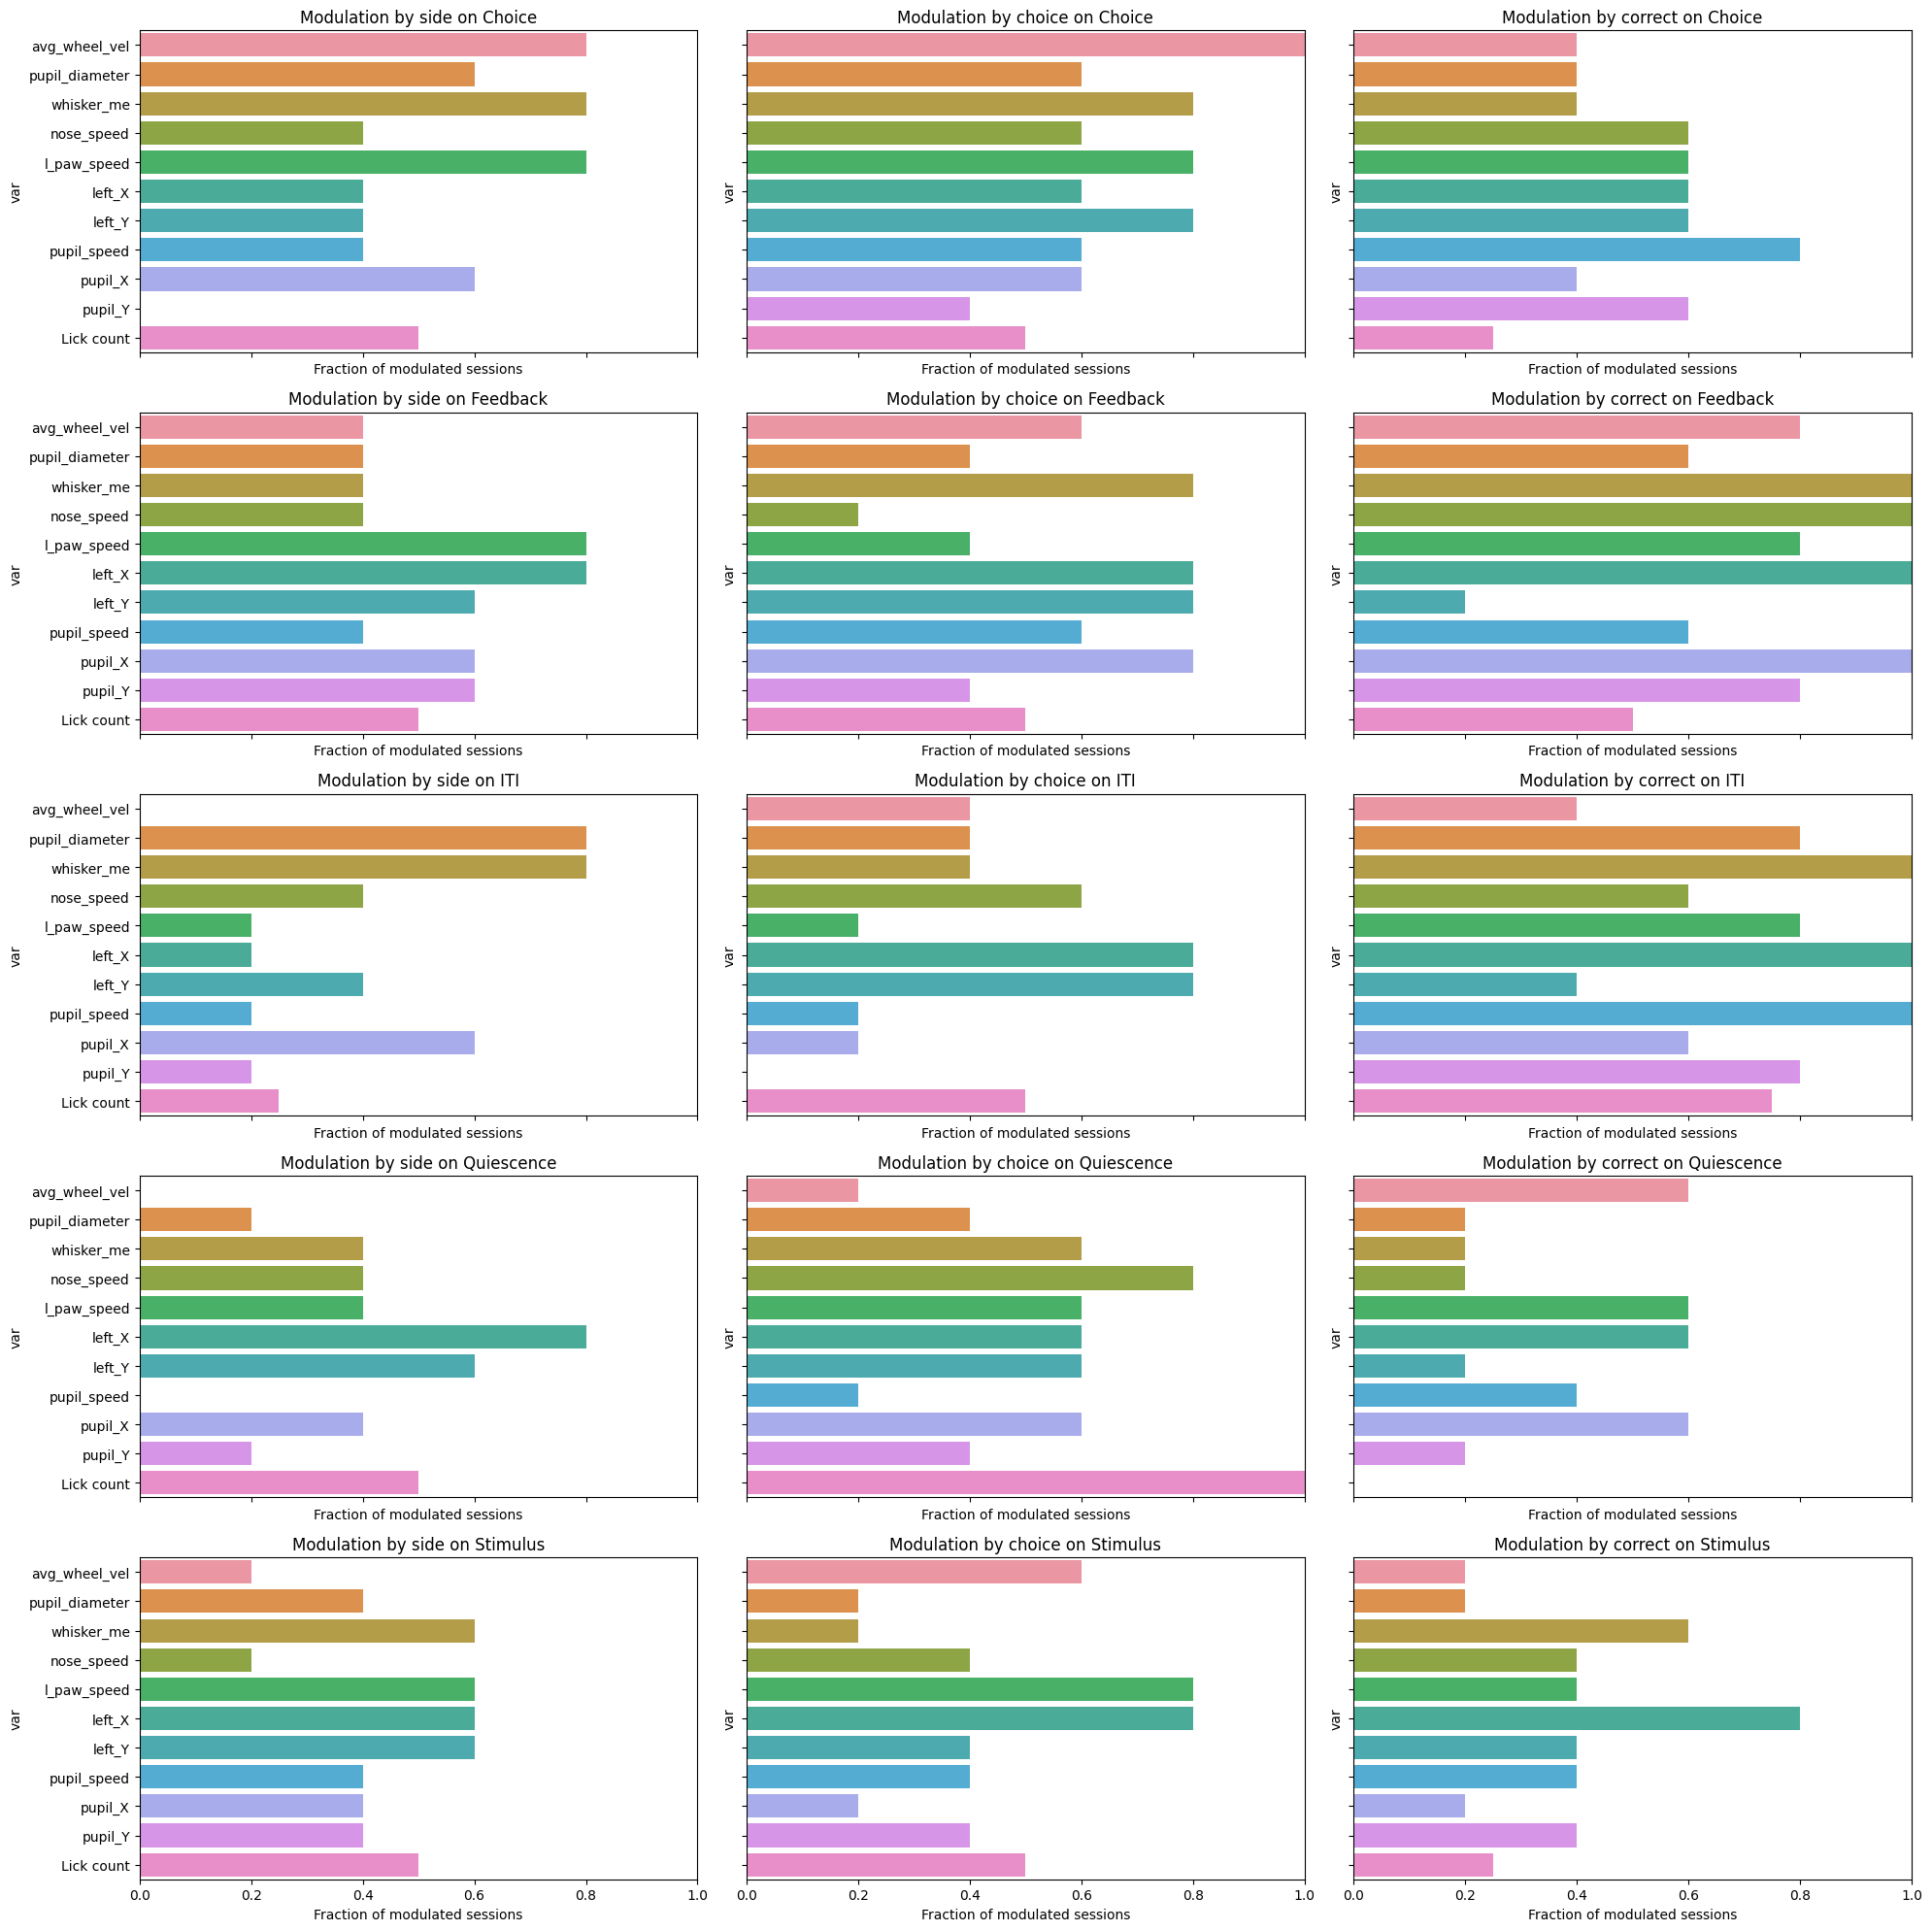

In [31]:

# Plot 
label='broader_label'
hue_types = ['side', 'choice', 'correct']
fig, ax = plt.subplots(nrows=5 , ncols=len(hue_types), sharex=True, sharey=True, figsize=[20, 20])
for h, hue in enumerate(hue_types):
    if hue in ['choice', 'side']:
        hue_names = np.array(['left', 'right'])
        hue_numbers = np.array([-1.0, 1.0])º
    elif hue == 'correct':
        hue_names = np.array(['correct', 'incorrect'])
        hue_numbers = np.array([1., 0.])

    p_values = stats_features_per_epoch_sess(idxs, session_all, matrix_all, matrix_all_unnorm, hue, label)

    trial_epochs = p_values['epoch'].unique()
    p_values.loc[p_values['significance']=='Significantly higher', 'significance'] = 1
    p_values.loc[p_values['significance']=='Significantly smaller', 'significance'] = 1
    p_values.loc[p_values['significance']=='Significantly higher', 'significance'] = 1
    p_values.loc[p_values['significance']=='Non significant', 'significance'] = 0
    for e, epoch in enumerate(trial_epochs):
        use_data = p_values.loc[p_values['epoch']==epoch]
        
        sns.barplot(y='var', x='significance', data=use_data, ax=ax[e, h], errorbar=None)  # order=['Non significant', 'Significant'],
        ax[e, h].set_xlabel('Fraction of modulated sessions')
        ax[e, h].set_title(str('Modulation by ' + hue + ' on ' + epoch))
        ax[e, h].set_xlim([0, 1])
plt.tight_layout()
plt.show()

Fitting mouse SWC_052


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

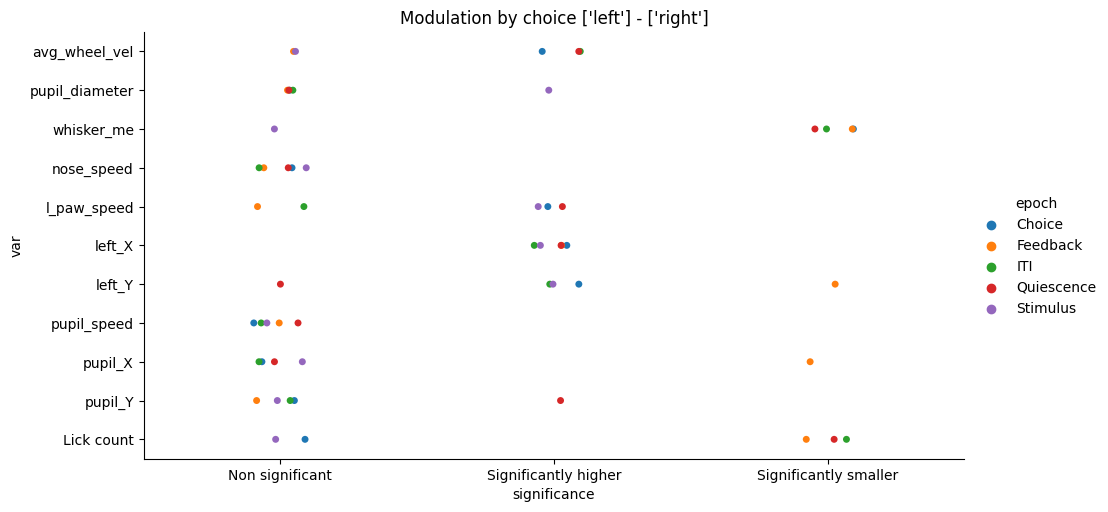

Fitting mouse ZFM-02369


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:426: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = quiescence_df.append(left_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:427: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(right_stim_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:428: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_df = all_df.append(left_df)
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:429: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

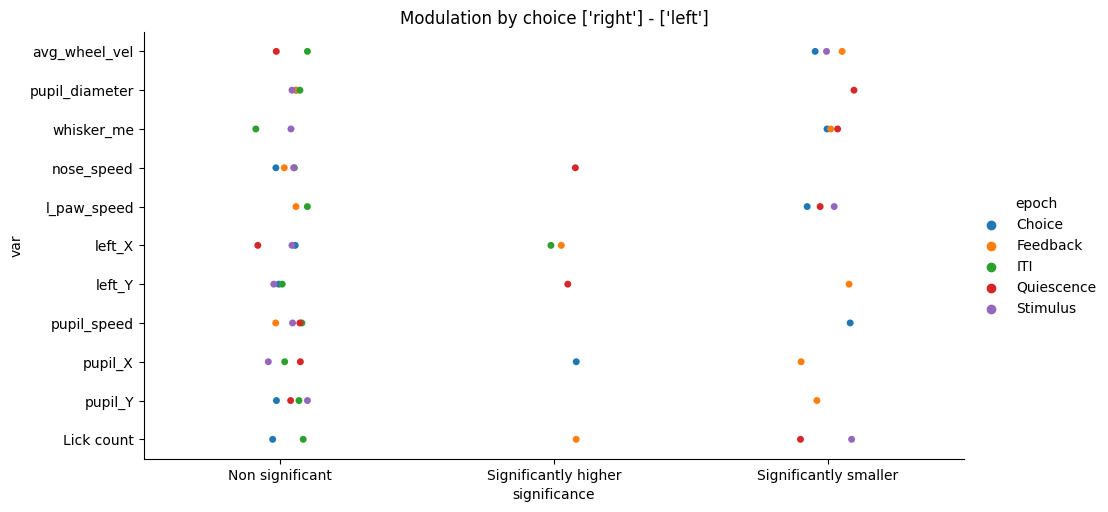

Fitting mouse SWC_061


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

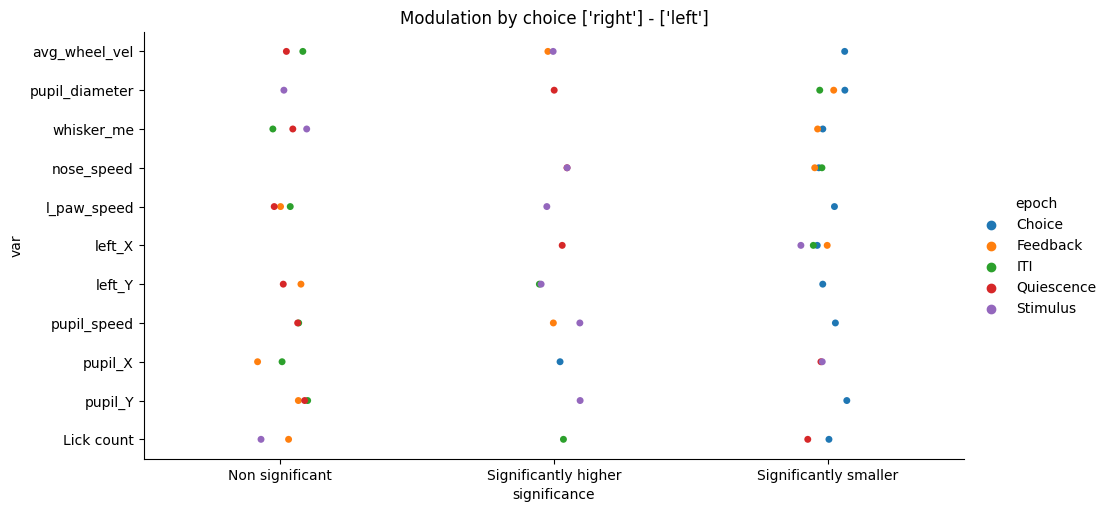

Fitting mouse CSHL049


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

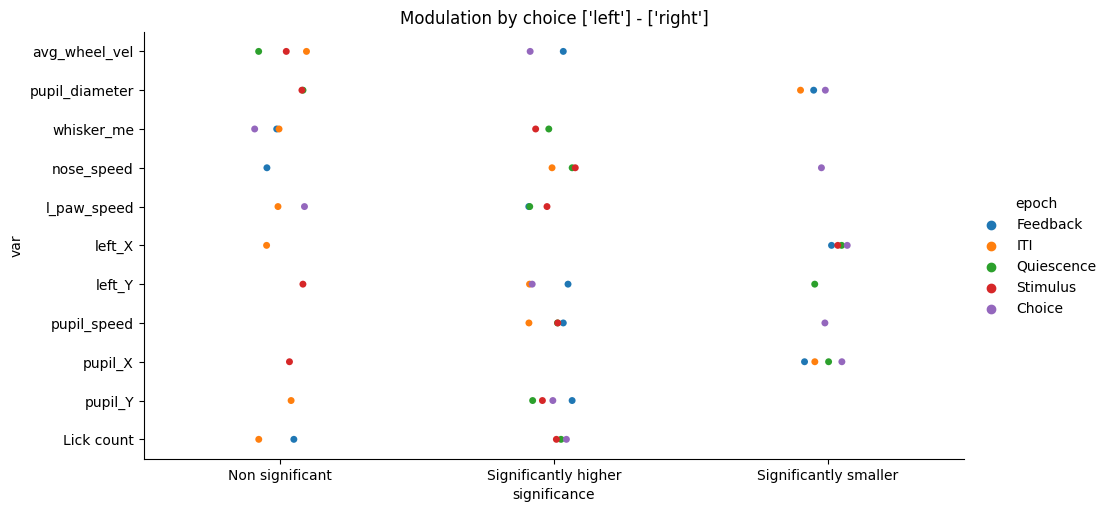

Fitting mouse NR_0019


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

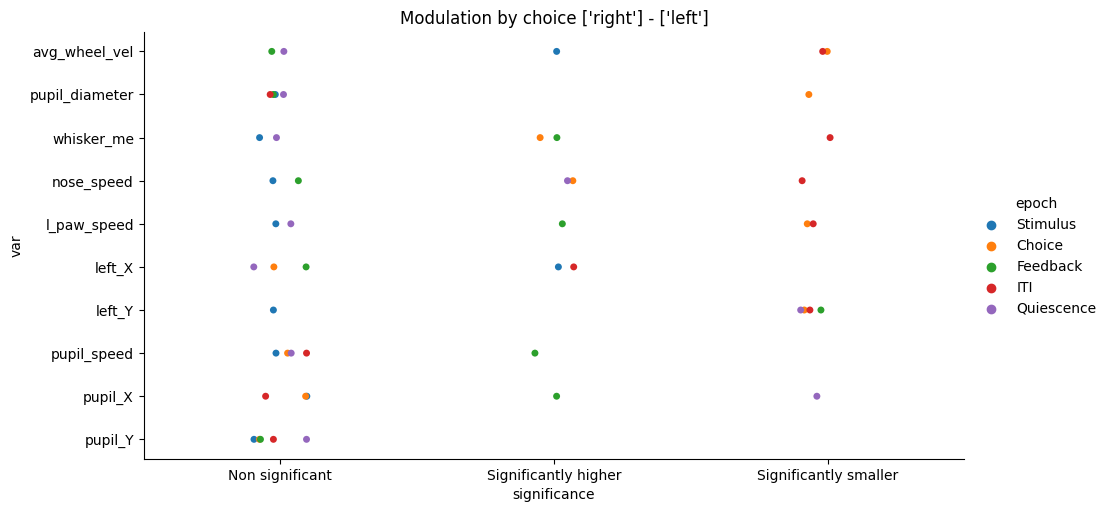

Fitting mouse SWC_053


/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['Trial'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:306: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['correct'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/plotting_functions.py:307: SettingWithCopyWarning: 
A value is t

KeyboardInterrupt: 

In [32]:
hue = 'choice'
label = 'broader_label'
order = ['Quiescence', 'Stimulus left', 'Stimulus right', 
         'Left choice', 'Right choice', 'Correct feedback', 
         'Incorrect feedback', 'ITI_correct', 'ITI_incorrect']
order = ['Quiescence', 'Stimulus', 'Choice', 'Feedback', 'ITI']

for m, mat in enumerate(idxs):
    if len(mat) > 35: 
            
        # Trials data
        session = mat[0:36]
        # Mouse name
        mouse_name = mat[37:]
            
        # Get mouse data
        session_trials = session_all[mouse_name][session]
        design_matrix = matrix_all[mouse_name][session]
        unnorm_mat = matrix_all_unnorm[mouse_name][session]
        
        if len(np.shape(design_matrix)) > 2:
            design_matrix = design_matrix[0]
            session_trials = session_trials[0]
            unnorm_mat = matrix_all_unnorm[mouse_name][0]
        
        " Prepare data "
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix
        bins = unnorm_mat['Bin']
        design_matrix_heading['Bin'] = bins
        
        # design_matrix_heading['Lick count'] = gaussian_filter1d(design_matrix_heading['Lick count'], sigma=1)  # TODO: how to decide on sigma here???
        #plt.hist(use_data['Lick count'])
        design_matrix_heading['avg_wheel_vel'] = np.abs(design_matrix_heading['avg_wheel_vel'])

        " Plot "
        # filename = str('features_per_epoch_' + mouse_name)
        # plot_features_per_epoch(design_matrix_heading, hue, label, order, filename)
        stats_features_per_epoch(design_matrix_heading, hue, label)
        
        